In [121]:
import numpy as np
import pandas as pd 
import tensorflow as tf 
from keras.layers import Input, Dense 
from keras.models import Model 
from sklearn.metrics import precision_recall_fscore_support 
import matplotlib.pyplot as plt 

In [168]:
# Create data
x_data = np.arange(0, 100, 0.01)
y_data = np.sin(x_data)
print('x.shape',x_data.shape)
print('y.shape',y_data.shape)

x.shape (10000,)
y.shape (10000,)


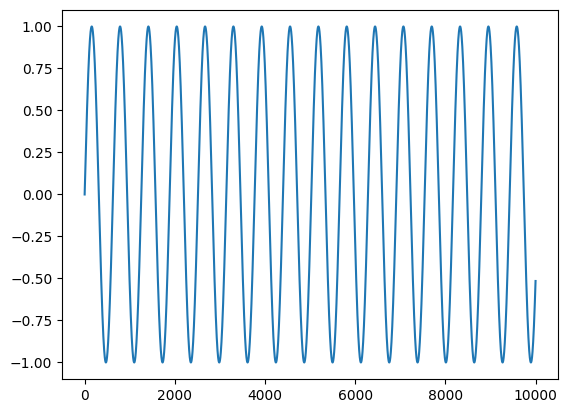

In [169]:
# Visualize
plt.plot(y_data)

In [172]:
# Add noise
noise = np.random.normal(0,0.2,10000)
print('noise.shape', noise.shape)
y_noise = y_data + noise

noise.shape (10000,)


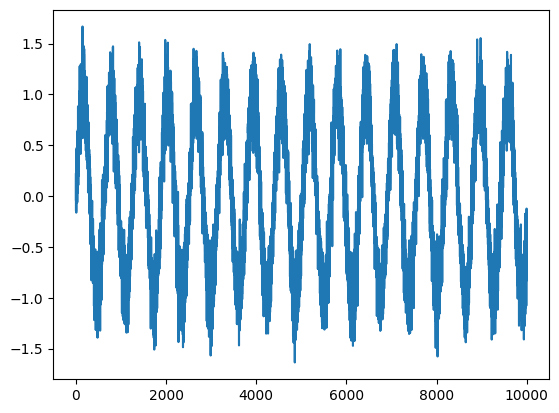

In [173]:
# Visualize
plt.plot(y_noise)

In [174]:
# Define the split time
split_time = 3000

# Get the train set
time_train = x_data[:split_time]
y_train = y_noise[:split_time]

# Get the validation set
time_valid = x_data[split_time:]
y_valid = y_noise[split_time:]

In [175]:


# Parameters
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000



In [176]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset


In [177]:


# Generate the dataset windows
dataset = windowed_dataset(y_train, window_size, batch_size, shuffle_buffer_size)



In [183]:
# Build the Model
model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x,axis=-1),
                           input_shape = [window_size]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x:x*100.0)
])

model_tune.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_18 (Lambda)          (None, 20, 1)             0         
                                                                 
 bidirectional_18 (Bidirecti  (None, 20, 64)           8704      
 onal)                                                           
                                                                 
 bidirectional_19 (Bidirecti  (None, 64)               24832     
 onal)                                                           
                                                                 
 dense_10 (Dense)            (None, 1)                 65        
                                                                 
 lambda_19 (Lambda)          (None, 1)                 0         
                                                                 
Total params: 33,601
Trainable params: 33,601
Non-tra

In [184]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(dataset, epochs=50, callbacks=[lr_schedule])


Epoch 1/50
94/94 [==============================] - 2s 8ms/step - loss: 9.8525 - lr: 1.0000e-08
Epoch 2/50
94/94 [==============================] - 0s 3ms/step - loss: 9.7043 - lr: 1.1220e-08
Epoch 3/50
94/94 [==============================] - 0s 3ms/step - loss: 9.5341 - lr: 1.2589e-08
Epoch 4/50
94/94 [==============================] - 0s 4ms/step - loss: 9.3426 - lr: 1.4125e-08
Epoch 5/50
94/94 [==============================] - 1s 8ms/step - loss: 9.1304 - lr: 1.5849e-08
Epoch 6/50
94/94 [==============================] - 0s 4ms/step - loss: 8.8911 - lr: 1.7783e-08
Epoch 7/50
94/94 [==============================] - 1s 7ms/step - loss: 8.6234 - lr: 1.9953e-08
Epoch 8/50
94/94 [==============================] - 1s 7ms/step - loss: 8.3263 - lr: 2.2387e-08
Epoch 9/50
94/94 [==============================] - 0s 4ms/step - loss: 7.9915 - lr: 2.5119e-08
Epoch 10/50
94/94 [==============================] - 1s 6ms/step - loss: 7.6176 - lr: 2.8184e-08
Epoch 11/50
94/94 [====================

In [185]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

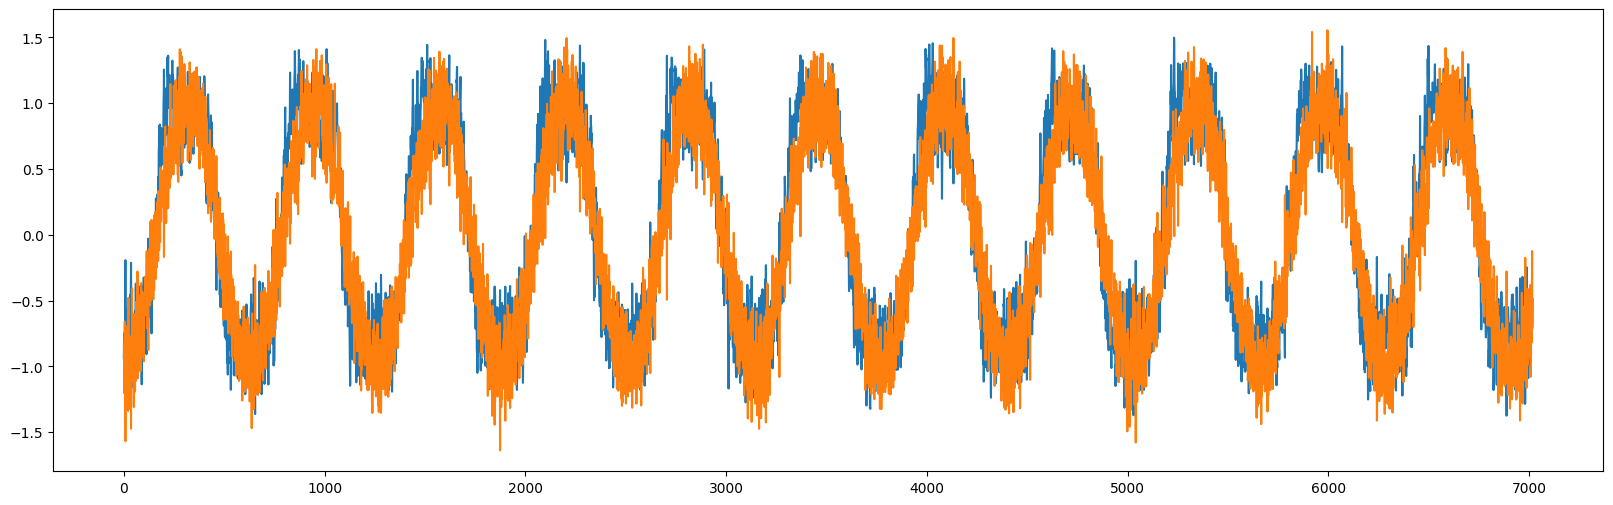

In [192]:
# Reduce the original series
forecast_series = y_noise[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results

plt.figure(figsize=(20,6))
plt.plot(results)
plt.plot(forecast_series)

In [198]:
# Save the model 
model.save("model_lstm")

INFO:tensorflow:Assets written to: model_lstm/assets


INFO:tensorflow:Assets written to: model_lstm/assets


In [199]:
loaded_model = tf.keras.models.load_model("model_lstm")

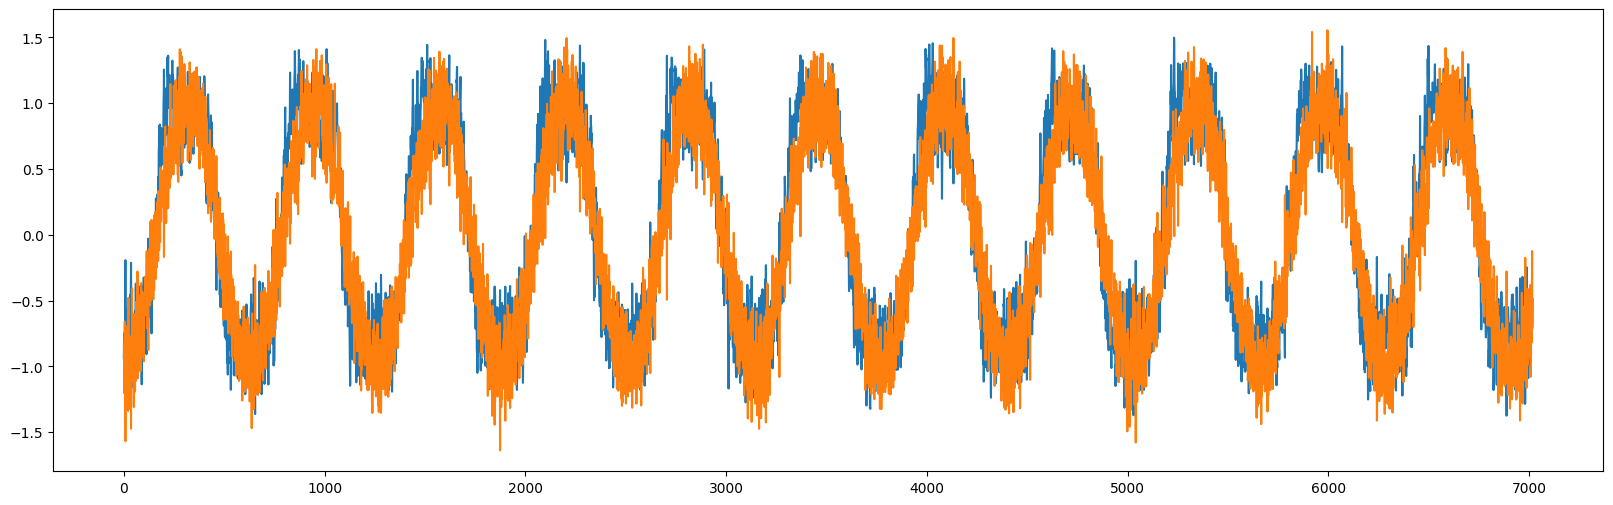

In [200]:
# Reduce the original series
forecast_series = y_noise[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(loaded_model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results

plt.figure(figsize=(20,6))
plt.plot(results)
plt.plot(forecast_series)